<center><h1> A/B Tests</h1></center>

# 1. Information

Используя данные https://www.kaggle.com/zhangluyuan/ab-testing провести анализ ab-теста на различие в двух выборках.

# 2. Fetching Data:

## 2.1 Import packages

In [1]:
import pandas as pd
import numpy as np
#import statsmodels.api as stats
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
%matplotlib inline
import warnings
import math
from statsmodels.stats.weightstats import *
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 2.2 Import data

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.shape

(294478, 5)

In [4]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


## 2.3 Data cleaning

Убираем повторяющихся пользователей

In [6]:
print(str(df['user_id'].nunique()) + ' /= ' + str(df.shape[0]))

290584 /= 294478


In [7]:
df.drop_duplicates(subset='user_id',inplace=True)

Убираем несоответствие при котором люди из контрольной группы получают новую страницу

In [8]:
false_indx = df[((df['group']=='treatment') ==(df['landing_page']=='new_page')) == False].index

In [9]:
df.drop(false_indx, inplace=True)

Формируем датасет для А/В - тестирования

In [10]:
treatment = list(df[((df['group']=='treatment'))==True].converted.values)
control = list(df[((df['group']=='control'))==True].converted.values)

In [11]:
print ('"control" set lenth = {}, "treatment" set = {}'.format(len(control), len(treatment)))

"control" set lenth = 144226, "treatment" set = 144314


In [12]:
# Delete elements
for i in range(len(treatment) - len(control)):
    random_item_from_list = np.random.choice(treatment)
    treatment.remove(random_item_from_list)

In [13]:
print ('"control" set lenth = {}, "treatment" set = {}'.format(len(control), len(treatment)))

"control" set lenth = 144226, "treatment" set = 144226


In [14]:
in_data = {'old_page':(treatment), 'new_page' :(control)}

In [15]:
data = pd.DataFrame(in_data)

In [16]:
data.head()

,old_page,new_page
0,1,0
1,1,0
2,1,1
3,1,0
4,1,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B00CBC8>,
      dtype=object)

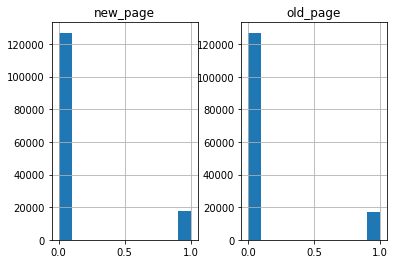

In [17]:
data.hist()

In [18]:
data.describe()

,old_page,new_page
count,144226.000000,144226.000000
mean,0.118744,0.120290
std,0.323488,0.325302
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


По значениям дисперсии и мат. ожидания можно предположить, что выборки схожи.

# 3. A/B Testing

Выборки независимые, так как в датасете был идентификатор пользователя, а дубликаты выкинуты.  
Применяем Z-test.

In [19]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = st.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [20]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [21]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - st.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return st.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - st.norm.cdf(z_stat)

In [22]:
print ("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(data.old_page, data.new_page))

95% confidence interval for a difference between proportions: [-0.003914, 0.000821]


In [23]:
print ("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(data.old_page, data.new_page)))

p-value: 0.200563


In [24]:
print ("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(data.old_page, data.new_page), 'less'))

p-value: 0.100282


In [25]:
print ("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(data.old_page, data.new_page), 'greater'))

p-value: 0.899718


# 4. Conclusion

Значения p-value достаточно большие и доверительный интервал проходит через 0. Это значит, что нулевую гипотезу о схожести выборок отбрасывать нельзя.